In [1]:
import mediapipe as mp
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import joblib
import json
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pyttsx3
import matplotlib.pyplot as plt

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

In [3]:
def extract_hand_landmarks_from_image(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.append(lm.x)
            landmarks.append(lm.y)
        return landmarks
    return None

In [4]:
def load_asl_landmarks_data(data_dir, img_size=(64, 64)):
    labels = []
    landmarks_list = []
    label_map = {}
    label_id = 0

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            label_map[label_id] = label
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                hand_landmarks = extract_hand_landmarks_from_image(img)
                if hand_landmarks:
                    landmarks_list.append(hand_landmarks)
                    labels.append(label_id)
            label_id += 1

    landmarks_list = np.array(landmarks_list)
    labels = np.array(labels)
    return landmarks_list, labels, label_map

### Plot functions

In [27]:
def plot_data_distribution(labels, label_map):
    unique, counts = np.unique(labels, return_counts=True)
    class_names = [label_map[str(label)] for label in unique]
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.xlabel('ASL Signs')
    plt.ylabel('Number of Samples')
    plt.title('Data Distribution by Class')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, label_map):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))
    
    disp.plot(cmap='Blues', xticks_rotation=90, ax=ax, values_format='.0f')
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

In [31]:
def plot_hand_landmarks(X, y, label_map):
    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        label_indices = np.where(y == label)
        sample_landmarks = X[label_indices].mean(axis=0).reshape(-1, 2)
        plt.subplot(len(unique_labels) // 3 + 1, 3, i + 1)
        plt.scatter(sample_landmarks[:, 0], sample_landmarks[:, 1])
        plt.title(label_map[str(label)])
        plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [22]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_scores, num_classes, label_map):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        y_binary = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_binary, y_scores[:, i])
        plt.plot(recall, precision, label=label_map[i])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [23]:
from sklearn.metrics import classification_report
import pandas as pd

def plot_classification_report(y_true, y_pred, label_map):
    report = classification_report(y_true, y_pred, target_names=list(label_map.values()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
    plt.title('Classification Report')
    plt.show()

In [5]:
landmarks_data_dir = 'asl_alphabet_train'
X_landmarks, y_landmarks, label_map = load_asl_landmarks_data(landmarks_data_dir)

c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [6]:
X_train_landmarks, X_test_landmarks, y_train_landmarks, y_test_landmarks = train_test_split(
    X_landmarks, y_landmarks, test_size=0.2, random_state=42)

(Saving numpy arrays so we don't have to reload)

In [9]:
np.savez('data.npz', xtrain=X_train_landmarks, xtest=X_test_landmarks, ytrain=y_train_landmarks, ytest=y_test_landmarks)

In [25]:
data = np.load('data.npz')
X_landmarks = np.concatenate((data['xtrain'], data['xtest']), axis=0)
y_landmarks = np.concatenate((data['ytrain'], data['ytest']), axis=0)
X_train_landmarks, X_test_landmarks, y_train_landmarks, y_test_landmarks = data['xtrain'], data['xtest'], data['ytrain'], data['ytest']

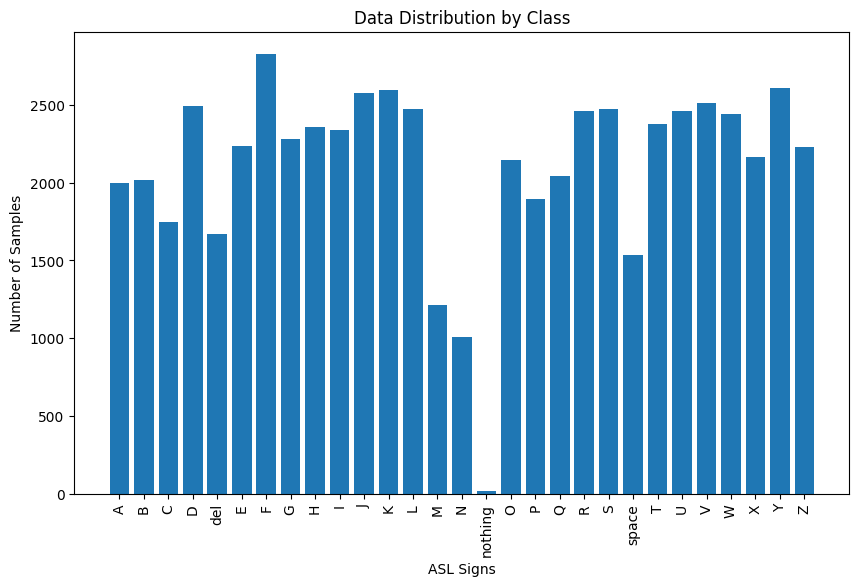

In [28]:
plot_data_distribution(y_landmarks, label_map)

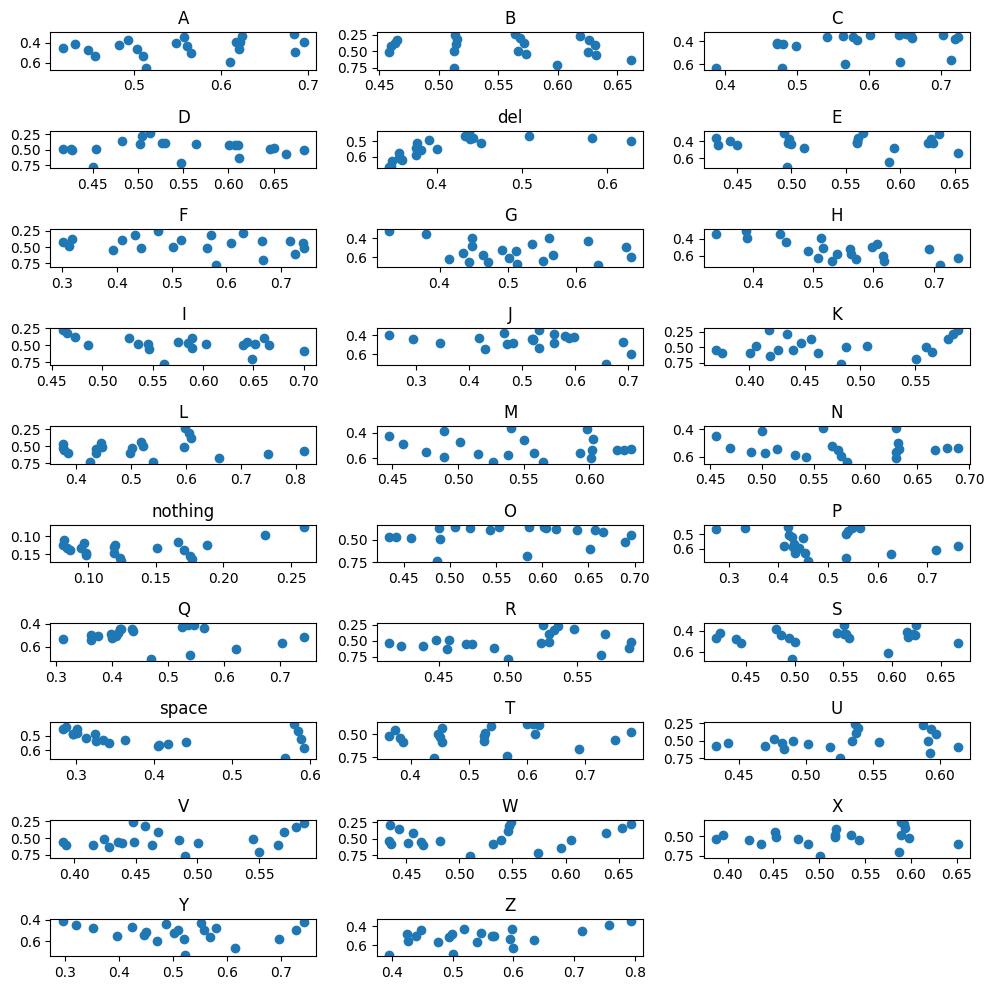

In [32]:
plot_hand_landmarks(X_landmarks, y_landmarks, label_map)

In [ ]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, checkpoint_dir="checkpoints", checkpoint_interval=100):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_interval = checkpoint_interval
        self.models = {}  
        self.means = None  
        self.stds = None  

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def standardize(self, X):
        if self.means is None or self.stds is None:
            self.means = np.mean(X, axis=0)
            self.stds = np.std(X, axis=0)
        
        self.stds[self.stds == 0] = 1
        return (X - self.means) / self.stds

    def fit(self, X, y, num_classes):
        X = self.standardize(X)
        
        for class_label in range(num_classes):
            print(f"\nTraining classifier for class {class_label}")

            # Create binary labels for the current class (One-vs-Rest)
            y_binary = np.where(y == class_label, 1, -1)
            
            model = BinarySVM(self.lr, self.lambda_param, self.n_iters, 
                              checkpoint_path=os.path.join(self.checkpoint_dir, f"svm_class_{class_label}.npz"),
                              checkpoint_interval=self.checkpoint_interval)
            model.fit(X, y_binary)
            
            self.models[class_label] = model

    def predict(self, X):
        X = (X - self.means) / self.stds
        
        scores = np.zeros((X.shape[0], len(self.models)))
        
        for class_label, model in self.models.items():
            scores[:, class_label] = model.decision_function(X)
        
        return np.argmax(scores, axis=1)


class BinarySVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, checkpoint_path=None, checkpoint_interval=100):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.checkpoint_path = checkpoint_path
        self.checkpoint_interval = checkpoint_interval
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        start_iter = 0
        
        if self.checkpoint_path and os.path.exists(self.checkpoint_path):
            checkpoint = np.load(self.checkpoint_path)
            self.w = checkpoint['w']
            self.b = checkpoint['b']
            start_iter = int(checkpoint['iteration'])
            print(f"Resuming from checkpoint at iteration {start_iter}")
        else:
            self.w = np.zeros(n_features)
            self.b = 0
            print("Starting training from scratch")

        # Convert labels to -1 and 1 for hinge loss
        y_ = np.where(y <= 0, -1, 1)

        for i in range(start_iter, self.n_iters):
            total_loss = 0
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    dw = 2 * self.lambda_param * self.w
                    db = 0
                else:
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    db = y_[idx]
                
                self.w -= self.lr * dw
                self.b -= self.lr * db
                
                loss = max(0, 1 - y_[idx] * (np.dot(x_i, self.w) - self.b))
                total_loss += loss

            if (i + 1) % self.checkpoint_interval == 0 or i == self.n_iters - 1:
                avg_loss = total_loss / n_samples
                print(f"Iteration {i + 1}/{self.n_iters} - Loss: {avg_loss:.4f}")
                
                if self.checkpoint_path:
                    np.savez(self.checkpoint_path, w=self.w, b=self.b, iteration=i + 1)
                    print(f"Checkpoint saved at iteration {i + 1}")

    def decision_function(self, X):
        return np.dot(X, self.w) - self.b

### Math explanation 
Using Soft-SVM:
$$ L = \min_{\mathbf{w}, b} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i (\mathbf{x}_i \cdot \mathbf{w} - b))
$$
$$
\text{If the condition is satisfied:} \quad y_i (\mathbf{x}_i \cdot \mathbf{w} - b) \geq 1
\quad \Rightarrow \quad
\frac{\partial L}{\partial \mathbf{w}} = 2 \mathbf{w}, \quad \frac{\partial L}{\partial b} = 0
$$

$$
\begin{bmatrix} \mathbf{w}_{k+1} & b_{k+1} \end{bmatrix} := 
\begin{bmatrix} \mathbf{w}_k & b_k \end{bmatrix} - \eta \cdot \left(\lambda 2 \mathbf{w}, \quad 0\right)
$$
$$
\text{Otherwise, if the condition is not satisfied:} \quad y_i (\mathbf{x}_i \cdot \mathbf{w} - b) < 1
\quad \Rightarrow \quad
\frac{\partial L}{\partial \mathbf{w}} = 2\mathbf{w} - y_i \mathbf{x}_i, \quad \frac{\partial L}{\partial b} = -y_i
$$

$$
\begin{bmatrix} \mathbf{w}_{k+1} & b_{k+1} \end{bmatrix} := 
\begin{bmatrix} \mathbf{w}_k & b_k \end{bmatrix} - \eta \cdot \left(\lambda 2\mathbf{w} - y_i \mathbf{x}_i, \quad y_i\right)
$$
$$
\lambda \quad \text{is the regularization for} \quad w
$$

In [13]:
num_classes = 29

svm = LinearSVM(learning_rate=0.001, lambda_param=0.01, n_iters=300, checkpoint_interval=300)
svm.fit(X_train_landmarks, y_train_landmarks, num_classes)


Training classifier for class 0
Starting training from scratch
Iteration 300/300 - Loss: 0.0551
Checkpoint saved at iteration 300

Training classifier for class 1
Starting training from scratch
Iteration 300/300 - Loss: 0.0393
Checkpoint saved at iteration 300

Training classifier for class 2
Starting training from scratch
Iteration 300/300 - Loss: 0.0134
Checkpoint saved at iteration 300

Training classifier for class 3
Starting training from scratch
Iteration 300/300 - Loss: 0.0339
Checkpoint saved at iteration 300

Training classifier for class 4
Starting training from scratch
Iteration 300/300 - Loss: 0.0204
Checkpoint saved at iteration 300

Training classifier for class 5
Starting training from scratch
Iteration 300/300 - Loss: 0.0646
Checkpoint saved at iteration 300

Training classifier for class 6
Starting training from scratch
Iteration 300/300 - Loss: 0.0186
Checkpoint saved at iteration 300

Training classifier for class 7
Starting training from scratch
Iteration 300/300 -

74m 29.2s training

In [ ]:
# Make predictions on the test set
predictions = svm.predict(X_test_landmarks)

# Calculate accuracy
accuracy = np.mean(predictions == y_test_landmarks)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.13%


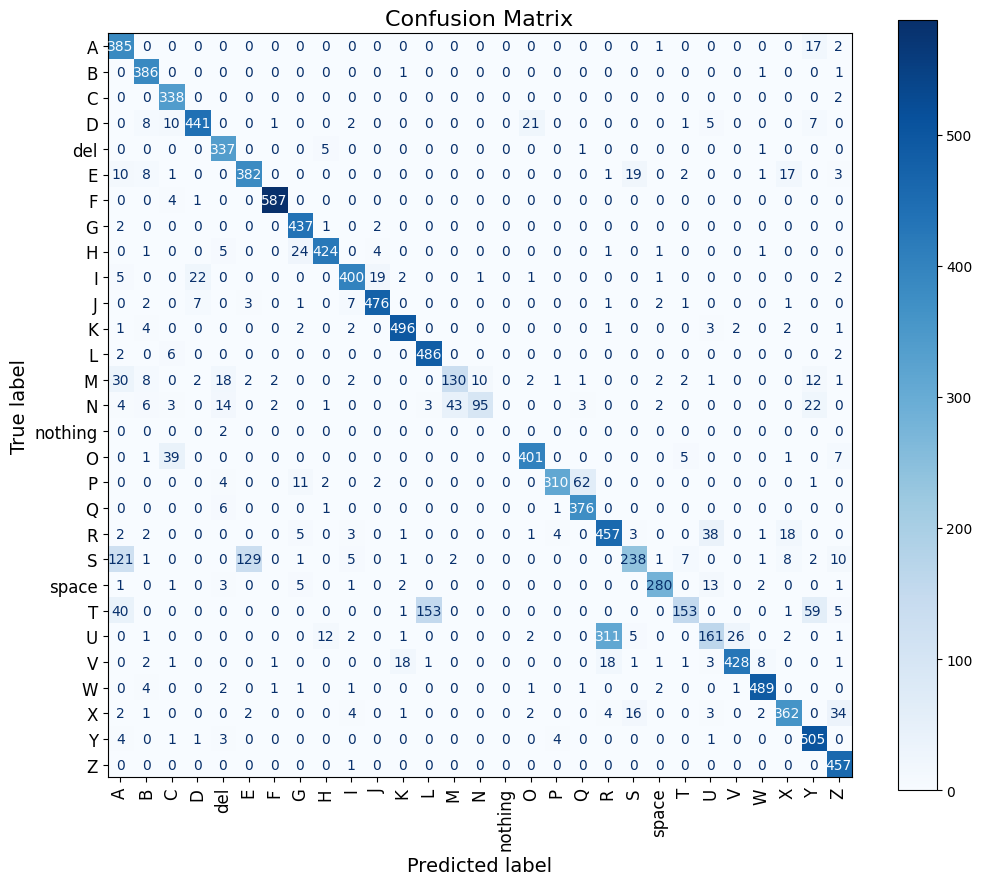

In [39]:
plot_confusion_matrix(y_test_landmarks, predictions, label_map)

c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

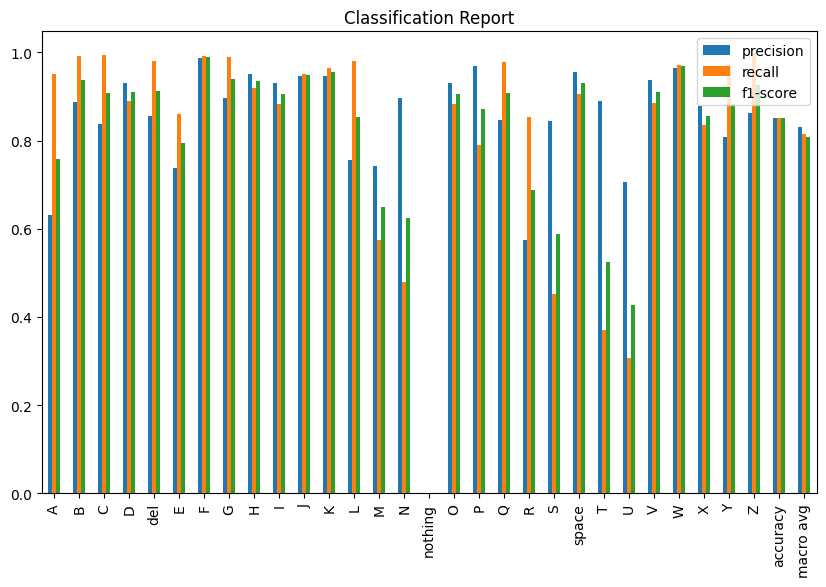

In [33]:
plot_classification_report(y_test_landmarks, predictions, label_map)

Adding a new feature: distances between each pair of landmarks and angles formed by three consecutive landmarks

In [12]:
from itertools import combinations

def compute_distances_and_angles(X):
    n_samples, n_landmarks, _ = X.shape 
    features = []
    
    for sample in X:
        sample_features = []
        
        # Calculate distances between all pairs of landmarks
        for (i, j) in combinations(range(n_landmarks), 2):
            dist = np.linalg.norm(sample[i] - sample[j])
            sample_features.append(dist)
        
        # Calculate angles for each triplet of landmarks
        for i in range(1, n_landmarks - 1):
            a, b, c = sample[i - 1], sample[i], sample[i + 1]
            ba = a - b
            bc = c - b
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
            angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
            sample_features.append(angle)
        
        features.append(sample_features)
    
    return np.array(features)

In [ ]:
newfeature = compute_distances_and_angles(X_landmarks.reshape(X_landmarks.shape[0], X_landmarks.shape[1]//2, 2))

In [47]:
X_landmarks = np.hstack((X_landmarks, newfeature))

In [48]:
X_landmarks.shape

(61183, 271)

In [49]:
X_train_landmarks, X_test_landmarks, y_train_landmarks, y_test_landmarks = train_test_split(
    X_landmarks, y_landmarks, test_size=0.2, random_state=42)

In [51]:
svm = LinearSVM(learning_rate=0.001, lambda_param=0.01, n_iters=300, checkpoint_interval=300)
svm.fit(X_train_landmarks, y_train_landmarks, num_classes)


Training classifier for class 0
Starting training from scratch
Iteration 300/300 - Loss: 0.0049
Checkpoint saved at iteration 300

Training classifier for class 1
Starting training from scratch
Iteration 300/300 - Loss: 0.0030
Checkpoint saved at iteration 300

Training classifier for class 2
Starting training from scratch
Iteration 300/300 - Loss: 0.0024
Checkpoint saved at iteration 300

Training classifier for class 3
Starting training from scratch
Iteration 300/300 - Loss: 0.0061
Checkpoint saved at iteration 300

Training classifier for class 4
Starting training from scratch
Iteration 300/300 - Loss: 0.0046
Checkpoint saved at iteration 300

Training classifier for class 5
Starting training from scratch
Iteration 300/300 - Loss: 0.0062
Checkpoint saved at iteration 300

Training classifier for class 6
Starting training from scratch
Iteration 300/300 - Loss: 0.0015
Checkpoint saved at iteration 300

Training classifier for class 7
Starting training from scratch
Iteration 300/300 -

50m 24.5s

In [53]:
# Make predictions on the test set
predictions = svm.predict(X_test_landmarks)

# Calculate accuracy
accuracy = np.mean(predictions == y_test_landmarks)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.48%


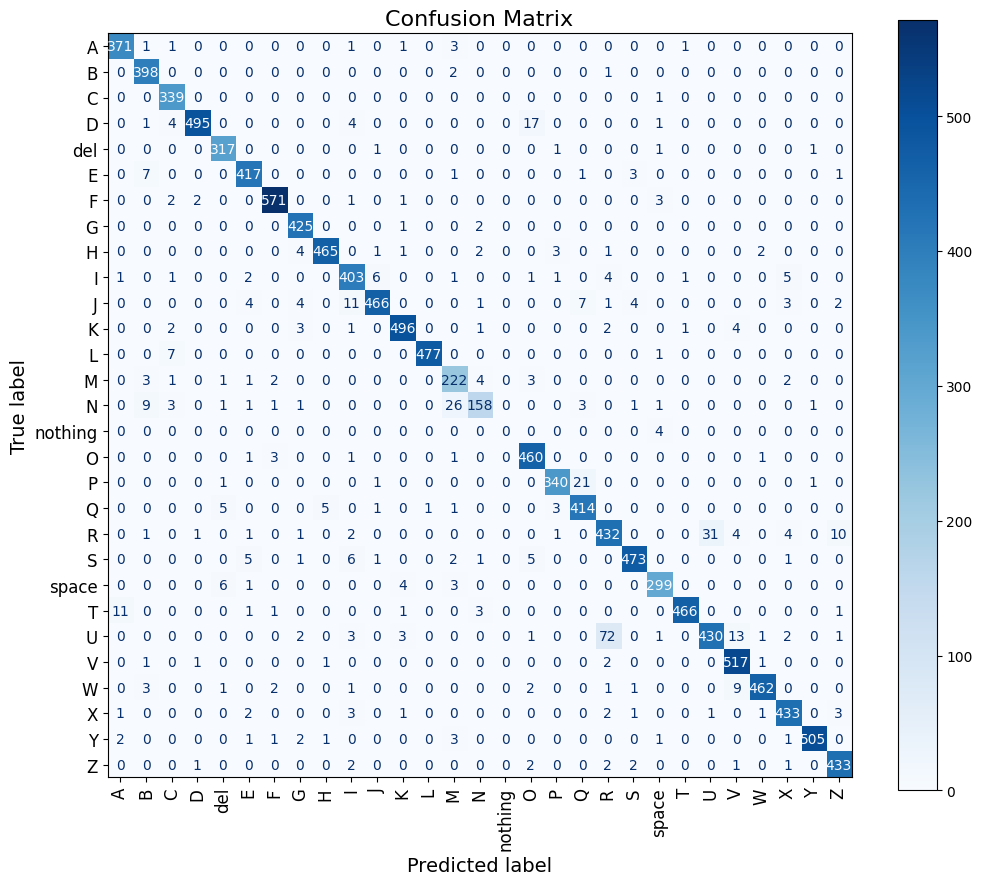

In [54]:
plot_confusion_matrix(y_test_landmarks, predictions, label_map)

c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

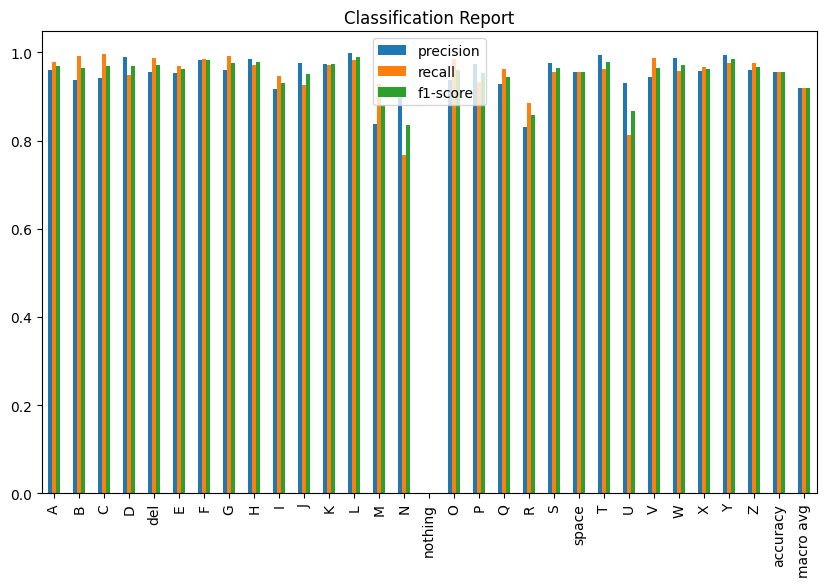

In [55]:
plot_classification_report(y_test_landmarks, predictions, label_map)

In [52]:
joblib.dump(svm, "svm_ovr_newfeature.joblib")

['svm_ovr_newfeature.joblib']

### Training with Scikit-learn SVM

In [ ]:
svm_model_landmarks = SVC(kernel='linear')
svm_model_landmarks.fit(X_train_landmarks, y_train_landmarks)

y_pred_landmarks = svm_model_landmarks.predict(X_test_landmarks)
accuracy_landmarks = accuracy_score(y_test_landmarks, y_pred_landmarks)
print(f"Accuracy with landmarks: {accuracy_landmarks * 100:.2f}%")

Accuracy with landmarks: 96.78%


In [ ]:
model_filename = input() 
model_filename += ".joblib"
joblib.dump(svm_model_landmarks, model_filename)

label_map_filename = 'label_map_landmarks.json'
with open(label_map_filename, 'w') as f:
    json.dump(label_map, f)

print(f"Model saved to {model_filename} and labels saved to {label_map_filename}.")

Model saved to svm_model_landmarks.joblib and labels saved to label_map_landmarks.json.


In [4]:
def speak_text(text):
    """Function to convert text to speech."""
    print("Speak text called")
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()

In [ ]:
sentence=""
click_detected = False  

def mouse_callback(event, x, y, flags, param):
    global click_detected
    global sentence
    if event == cv2.EVENT_LBUTTONDOWN: 
        click_detected = True 
    elif event == cv2.EVENT_RBUTTONDOWN:
        sentence="" 

def run_webcam_hand_sign_recognition(model, label_map, detection_confidence=0.7):
    global sentence, click_detected
    
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=detection_confidence)
    
    cap = cv2.VideoCapture(0) 

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    cv2.namedWindow('Hand Sign Recognition')  
    cv2.setMouseCallback('Hand Sign Recognition', mouse_callback) 
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break
        # Flip the frame horizontally
        frame = cv2.flip(frame, 1)
        
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = hands.process(img_rgb)
        
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.append(lm.x)
                landmarks.append(lm.y)
            landmarks = np.array(landmarks).reshape(1, -1)  # Reshape to match model input
            landmarks_reshaped = landmarks.reshape(1, 21, 2)
            additional_features = compute_distances_and_angles(landmarks_reshaped)
            landmarks_flat = landmarks_reshaped.reshape(1, 42)
            landmarks_enhanced = np.hstack((landmarks_flat, additional_features))
    
            prediction = model.predict(landmarks_enhanced)
            hand_sign = label_map[str(prediction[0])]
            if click_detected:
                if hand_sign == "space":
                    sentence += " "
                elif hand_sign == "del":
                    if len(sentence)>1:
                        sentence = sentence[:-1]
                    else:
                        sentence = ""
                else:
                    sentence += f"{hand_sign}"
                click_detected = False 
            h, w, _ = frame.shape
            x_coords = [lm.x * w for lm in hand_landmarks.landmark]
            y_coords = [lm.y * h for lm in hand_landmarks.landmark]
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))
            
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            
            text_x = x_min
            text_y = y_min - 10  
            cv2.putText(frame, f'Prediction: {hand_sign}', (text_x, text_y), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            #cv2.putText(frame, f'Confidence: {confidence_score:.2f}', (text_x, text_y + 20), 
                        #cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(frame, f'Sentence: {sentence.strip()}', (20, 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
        cv2.imshow('Hand Sign Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        elif cv2.waitKey(1) & 0xFF == ord('s'):
            speak_text(sentence)
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
inp = int(input())
if inp==0:
    svm_model_landmarks = joblib.load('model/scikit-learn-svm.joblib')
else:
    svm_model_landmarks = joblib.load('model/svm_ovr_newfeature.joblib')
with open('model/label_map_landmarks.json', 'r') as f:
    label_map = json.load(f)

In [13]:
run_webcam_hand_sign_recognition(svm_model_landmarks, label_map)

Speak text called
Speak text called
Speak text called
Speak text called
Speak text called
Speak text called
